# Multiclass Image Classification using CNN (KERAS)


> Written by **Baruch Baksht** and **Israel Rolnik**


In this project, we built a model that classifies images from the following categories: 

*   Cloudy
*   Rain
*   Shein
*   Sunrise

The data were taken from [this](https://data.mendeley.com/datasets/4drtyfjtfy/1) database.


In [ ]:
import os
import gc
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import zipfile
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##Download the data from the Internet, save and arrange them locally.

In [ ]:
if not os.path.exists("/Weather_data"):
  !wget --no-check-certificate https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
  os.rename("/content/4drtyfjtfy-1.zip", "/content/Weather_data.zip")

  base_dir = '/Weather_data'
  os.mkdir(base_dir)
  
  train_dir = os.path.join(base_dir, 'train')
  os.mkdir(train_dir)
  validation_dir = os.path.join(base_dir, 'validation')
  os.mkdir(validation_dir)

  train_cloud_dir = os.path.join(train_dir, 'cloudy')
  train_rain_dir = os.path.join(train_dir, 'rain')
  train_sunrise_dir = os.path.join(train_dir, 'sunrise')
  train_shine_dir = os.path.join(train_dir, 'shine')

  os.mkdir(train_cloud_dir)
  os.mkdir(train_rain_dir)
  os.mkdir(train_sunrise_dir)
  os.mkdir(train_shine_dir)

  validation_cloud_dir = os.path.join(validation_dir, 'cloudy')
  validation_rain_dir = os.path.join(validation_dir, 'rain')
  validation_sunrise_dir = os.path.join(validation_dir, 'sunrise')
  validation_shine_dir = os.path.join(validation_dir, 'shine')
  os.mkdir(validation_cloud_dir)
  os.mkdir(validation_rain_dir)
  os.mkdir(validation_sunrise_dir)
  os.mkdir(validation_shine_dir)

  cloud_dir = os.path.join(validation_dir, 'cloudy')

  shutil.move("/content/Weather_data.zip", "/Weather_data/Weather_data.zip")

  zip_ref = zipfile.ZipFile("/Weather_data/Weather_data.zip", 'r')
  zip_ref.extractall('/Weather_data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile("/Weather_data/dataset2.zip", 'r')
  zip_ref.extractall('/Weather_data')
  zip_ref.close()

  os.rename("/Weather_data/dataset2", "/Weather_data/data")

  data_dir = '/Weather_data/data'
  cloud_dir = os.path.join(data_dir, 'cloudy')
  rain_dir = os.path.join(data_dir, 'rain')
  sunrise_dir = os.path.join(data_dir, 'sunrise')
  shine_dir = os.path.join(data_dir, 'shine')
  os.mkdir(cloud_dir)
  os.mkdir(rain_dir)
  os.mkdir(sunrise_dir)
  os.mkdir(shine_dir)


  files = os.listdir(data_dir)

  for f in files:
    if f.startswith("cloudy"):
        shutil.move(os.path.join(data_dir, f), cloud_dir)
    elif f.startswith("rain"):
        shutil.move(os.path.join(data_dir, f), rain_dir)
    elif f.startswith("sunrise"):
        shutil.move(os.path.join(data_dir, f), sunrise_dir)
    elif f.startswith("shine"):
        shutil.move(os.path.join(data_dir, f), shine_dir)


--2021-06-10 10:34:09--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.56.64
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.56.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95592747 (91M) [application/octet-stream]
Saving to: ‘4drtyfjtfy-1.zip’

4drtyfjtfy-1.zip    100%[===================>]  91.16M  20.0MB/s    in 5.7s    

2021-06-10 10:34:15 (16.0 MB/s) - ‘4drtyfjtfy-1.zip’ saved [95592747/95592747]



In [ ]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)

        if os.path.getsize(file) > 0:
            files.append(filename)

    training_length = int(len(files) * SPLIT_SIZE)
    valid_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    valid_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TRAINING, filename) 
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(VALIDATION, filename)
        copyfile(this_file, destination)

In [ ]:
import os
import random
from shutil import copyfile

split_size = 0.85

split_data(cloud_dir, train_cloud_dir, validation_cloud_dir, split_size)
split_data(rain_dir, train_rain_dir, validation_rain_dir, split_size)
split_data(sunrise_dir, train_sunrise_dir, validation_sunrise_dir, split_size)
split_data(shine_dir, train_shine_dir, validation_shine_dir, split_size)

##Deep Learning with Data Augumentation

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

**data_generator(is_augmentation):** A function that receives Boolean variable "is_augmentation" to determine if to use augmentation and returns the train and validation sets.

In [ ]:
def data_generator(is_augmentation = False):

  if(is_augmentation):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)
  else:
    train_datagen = ImageDataGenerator(rescale=1./255)

  # Note that the validation data should not be augmented!
  val_datagen = ImageDataGenerator(rescale=1./255)

  # Flow training images in batches of 32 using train_datagen generator
  train_generator = train_datagen.flow_from_directory(
          train_dir,  # This is the source directory for training images
          target_size=(150, 150),  # All images will be resized to 150x150
          batch_size=20,
          # Since we use binary_crossentropy loss, we need binary labels
          class_mode='categorical')

  # Flow validation images in batches of 32 using val_datagen generator
  validation_generator = val_datagen.flow_from_directory(
          validation_dir,
          target_size=(150, 150),
          batch_size=20,
          class_mode='categorical')
  
  return train_generator, validation_generator

**def create_model(is_dropout = False, is_augmentation = False):**  Function that receives as input Boolean variables "is_dropout" and "is_augmentation" to determine if dropout and if to use augmentation and returns the model after  the fit.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
from tensorflow import keras

def create_model(is_dropout = False, is_augmentation = False):
  
  train_generator, validation_generator = data_generator(is_augmentation)

  if is_dropout:
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
  else:
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))

  model.summary()

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  
  history = model.fit_generator(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=validation_generator
                              )

  return history, model

**def resultsEvaluation(history):** Function to display the results, The function receives the learning results of the model.

In [ ]:
def resultsEvaluation(history):
  # Retrieve a list of accuracy results on training and validation data
  # sets for each training epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  # Retrieve a list of list results on training and validation data
  # sets for each training epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get number of epochs
  epochs = range(len(acc))

  # Plot training and validation accuracy per epoch
  plt.plot(epochs, acc, 'r', label="Training accuracy")
  plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  # Plot training and validation loss per epoch
  plt.plot(epochs, loss, 'r', label="Training loss")
  plt.plot(epochs, val_loss , 'b', label="Validation loss")
  plt.title('Training and validation loss')
  plt.legend()


In [ ]:
history, model = create_model(is_dropout = False, is_augmentation= False)

Found 955 images belonging to 4 classes.
Found 170 images belonging to 4 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


48/48 [==============================] - 39s 152ms/step - loss: 0.8710 - accuracy: 0.5853 - val_loss: 0.5897 - val_accuracy: 0.7882
Epoch 2/50
48/48 [==============================] - 7s 141ms/step - loss: 0.7013 - accuracy: 0.7037 - val_loss: 0.6466 - val_accuracy: 0.7000
Epoch 3/50
48/48 [==============================] - 7s 141ms/step - loss: 0.5610 - accuracy: 0.7927 - val_loss: 0.6932 - val_accuracy: 0.6765
Epoch 4/50
48/48 [==============================] - 7s 138ms/step - loss: 0.5133 - accuracy: 0.8168 - val_loss: 0.4087 - val_accuracy: 0.8588
Epoch 5/50
48/48 [==============================] - 7s 141ms/step - loss: 0.3603 - accuracy: 0.8733 - val_loss: 0.3281 - val_accuracy: 0.8706
Epoch 6/50
48/48 [==============================] - 7s 141ms/step - loss: 0.3292 - accuracy: 0.8764 - val_loss: 0.3025 - val_accuracy: 0.8882
Epoch 7/50
48/48 [==============================] - 7s 139ms/step - loss: 0.3052 - accuracy: 0.8880 - val_loss: 0.2732 - val_accuracy: 0.8941
Epoch 8/50
48/48

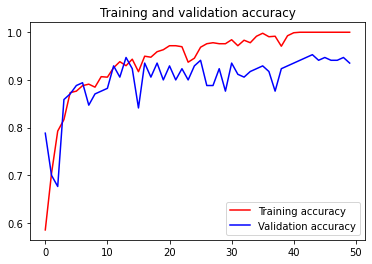

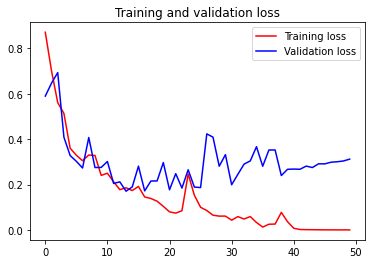

In [ ]:
resultsEvaluation(history)

In [ ]:
history, model = create_model(is_dropout = True, is_augmentation= False)

Found 955 images belonging to 4 classes.
Found 170 images belonging to 4 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
______________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


48/48 [==============================] - 7s 145ms/step - loss: 0.8884 - accuracy: 0.5759 - val_loss: 0.6226 - val_accuracy: 0.7412
Epoch 2/50
48/48 [==============================] - 7s 142ms/step - loss: 0.5407 - accuracy: 0.8136 - val_loss: 0.4414 - val_accuracy: 0.8353
Epoch 3/50
48/48 [==============================] - 7s 139ms/step - loss: 0.4946 - accuracy: 0.8147 - val_loss: 0.3925 - val_accuracy: 0.8529
Epoch 4/50
48/48 [==============================] - 7s 140ms/step - loss: 0.4500 - accuracy: 0.8387 - val_loss: 0.4265 - val_accuracy: 0.8412
Epoch 5/50
48/48 [==============================] - 7s 142ms/step - loss: 0.4975 - accuracy: 0.8168 - val_loss: 0.5084 - val_accuracy: 0.8235
Epoch 6/50
48/48 [==============================] - 7s 141ms/step - loss: 0.3989 - accuracy: 0.8597 - val_loss: 0.3868 - val_accuracy: 0.8471
Epoch 7/50
48/48 [==============================] - 7s 141ms/step - loss: 0.3319 - accuracy: 0.8754 - val_loss: 0.3038 - val_accuracy: 0.8588
Epoch 8/50
48/48 

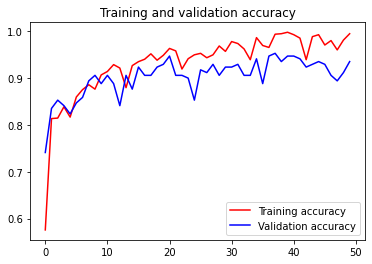

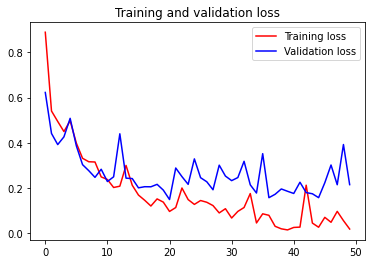

In [ ]:
resultsEvaluation(history)

In [ ]:
history, model = create_model(is_dropout = False, is_augmentation= True)

Found 955 images belonging to 4 classes.
Found 170 images belonging to 4 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
______________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


48/48 [==============================] - 11s 223ms/step - loss: 0.8716 - accuracy: 0.6052 - val_loss: 0.5923 - val_accuracy: 0.7176
Epoch 2/50
48/48 [==============================] - 11s 220ms/step - loss: 0.7400 - accuracy: 0.7120 - val_loss: 0.5051 - val_accuracy: 0.7824
Epoch 3/50
48/48 [==============================] - 10s 218ms/step - loss: 0.5919 - accuracy: 0.7665 - val_loss: 0.4406 - val_accuracy: 0.8235
Epoch 4/50
48/48 [==============================] - 10s 212ms/step - loss: 0.5115 - accuracy: 0.8010 - val_loss: 0.3784 - val_accuracy: 0.8294
Epoch 5/50
48/48 [==============================] - 11s 219ms/step - loss: 0.5415 - accuracy: 0.7885 - val_loss: 0.4033 - val_accuracy: 0.8471
Epoch 6/50
48/48 [==============================] - 10s 218ms/step - loss: 0.4736 - accuracy: 0.8262 - val_loss: 0.3309 - val_accuracy: 0.8765
Epoch 7/50
48/48 [==============================] - 11s 226ms/step - loss: 0.4504 - accuracy: 0.8398 - val_loss: 0.4079 - val_accuracy: 0.8529
Epoch 8/50

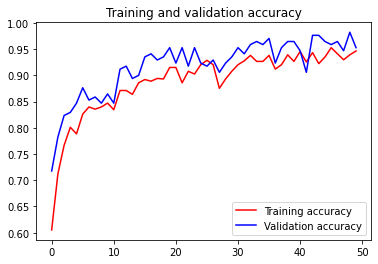

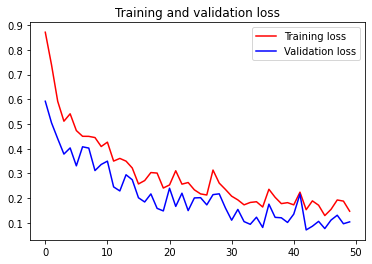

In [ ]:
resultsEvaluation(history)

In [ ]:
history, model = create_model(is_dropout = True, is_augmentation= True)

Found 955 images belonging to 4 classes.
Found 170 images belonging to 4 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
______________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
48/48 [==============================] - 11s 228ms/step - loss: 0.9524 - accuracy: 0.5361 - val_loss: 0.6688 - val_accuracy: 0.7588
Epoch 2/50
48/48 [==============================] - 10s 214ms/step - loss: 0.7373 - accuracy: 0.6712 - val_loss: 0.5076 - val_accuracy: 0.7588
Epoch 3/50
48/48 [==============================] - 10s 216ms/step - loss: 0.5602 - accuracy: 0.7707 - val_loss: 0.5145 - val_accuracy: 0.7941
Epoch 4/50
48/48 [==============================] - 10s 216ms/step - loss: 0.4994 - accuracy: 0.8073 - val_loss: 0.4753 - val_accuracy: 0.7941
Epoch 5/50
48/48 [==============================] - 10s 218ms/step - loss: 0.4700 - accuracy: 0.8314 - val_loss: 0.4092 - val_accuracy: 0.8706
Epoch 6/50
48/48 [==============================] - 10s 219ms/step - loss: 0.4127 - accuracy: 0.8555 - val_loss: 0.3206 - val_accuracy: 0.8882
Epoch 7/50
48/48 [==============================] - 10s 215ms/step - loss: 0.3895 - accuracy: 0.8555 - val_loss: 0.4356 - val_accuracy: 0.8647

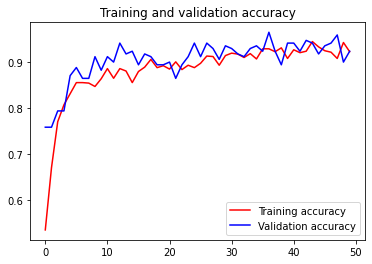

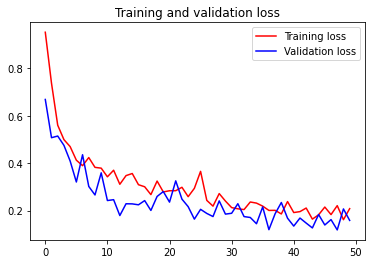

In [ ]:
resultsEvaluation(history)

##Checking the model with picture from the internet.

In [ ]:
# vgg16 model used for transfer learning on the dogs and cats dataset
import sys
from matplotlib import pyplot
#from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(4, activation='softmax')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
  # Plot training and validation accuracy per epoch
  plt.plot(history.history['loss'], 'r', label="Training loss")
  plt.plot(history.history['val_loss'], 'b', label="Validation loss")
  plt.title('Training and validation loss')
  plt.legend()

  plt.figure()

  # Plot training and validation loss per epoch
  plt.plot(history.history['accuracy'], 'r', label="Training accuracy")
  plt.plot(history.history['val_accuracy'], 'b', label="Validation accuracy")
  plt.title('Training and validation accuracy')
  plt.legend()
 

# run the test harness for evaluating a model
def run_test_harness():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(featurewise_center=True)
  # specify imagenet mean values for centering
  datagen.mean = [123.68, 116.779, 103.939]
  # prepare iterator
  train_it = datagen.flow_from_directory(train_dir,
    class_mode='categorical', batch_size=64, target_size=(224, 224))
  test_it = datagen.flow_from_directory(validation_dir,
    class_mode='categorical', batch_size=64, target_size=(224, 224))
  # fit model
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
  # evaluate model
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
  print('accuracy = %.3f' % (acc * 100.0))
  # learning curves
  return history

history = run_test_harness()


58900480/58889256 [==============================] - 1s 0us/step
Found 955 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Found 170 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
15/15 [==============================] - 47s 2s/step - loss: 2.9176 - accuracy: 0.7018 - val_loss: 0.9005 - val_accuracy: 0.8882
Epoch 2/10
15/15 [==============================] - 9s 585ms/step - loss: 0.5720 - accuracy: 0.9496 - val_loss: 0.2550 - val_accuracy: 0.9588
Epoch 3/10
15/15 [==============================] - 9s 578ms/step - loss: 0.0917 - accuracy: 0.9860 - val_loss: 0.2645 - val_accuracy: 0.9647
Epoch 4/10
15/15 [==============================] - 9s 590ms/step - loss: 0.0025 - accuracy: 0.9984 - val_loss: 0.2972 - val_accuracy: 0.9706
Epoch 5/10
15/15 [==============================] - 9s 573ms/step - loss: 0.0025 - accuracy: 0.9987 - val_loss: 0.2720 - val_accuracy: 0.9706
Epoch 6/10
15/15 [==============================] - 9s 581ms/step - loss: 4.7989e-05 - accuracy: 1.0000 - val_loss: 0.2646 - val_accuracy: 0.9647
Epoch 7/10
15/15 [==============================] - 9s 584ms/step - loss: 1.7668e-05 - accuracy: 1.0000 - val_loss: 0.2644 - val_accuracy: 0.9647


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


accuracy = 96.471


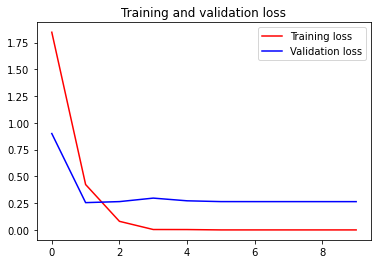

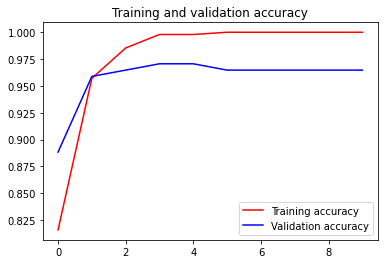

In [ ]:
summarize_diagnostics(history)

1/1 [==============================] - 0s 165ms/step


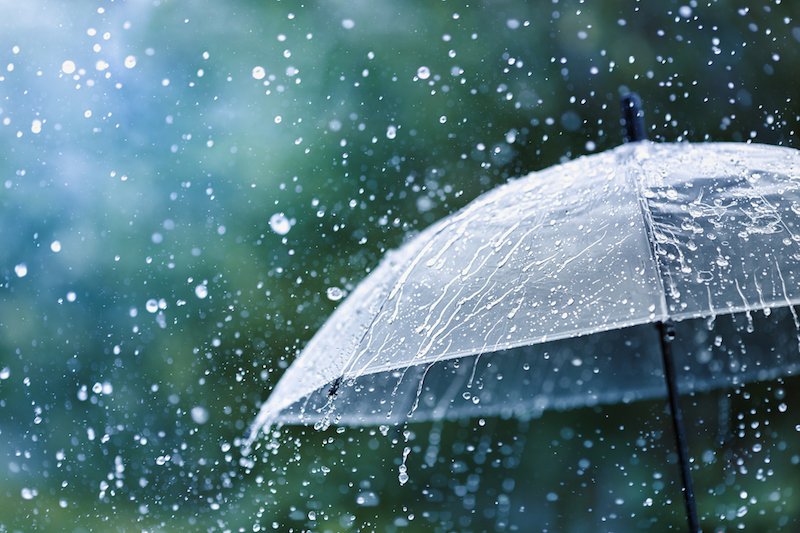

The image is predicted by the model as: rain


In [ ]:
## Test Performance on Test Data
import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from google.colab.patches import cv2_imshow
import urllib.request
import cv2

def preprocess_image(imgURL):
    test_img_dir = '/Weather_data/test_img'
    if not os.path.exists(test_img_dir): os.mkdir(test_img_dir)
    test_img = '/Weather_data/test_img/img.jpg'

    urllib.request.urlretrieve(imgURL, test_img)

    img = load_img(test_img, target_size = (150, 150))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img /= 255.
    
    test_preprocessed_images = np.vstack([img])

    array = model.predict(test_preprocessed_images, batch_size=1, verbose=1)
    answer = np.argmax(array, axis=1)

    img = cv2.imread(test_img, cv2.IMREAD_UNCHANGED)
    cv2_imshow(img)

    res = ['Cloudy', 'rain', 'shine', 'sunrise']

    print("The image is predicted by the model as: " + res[answer[0]])




preprocess_image("https://wpcdn.us-east-1.vip.tn-cloud.net/www.myneworleans.com/content/uploads/2021/04/r/y/gettyimages-1257951336.jpg")